# Github Star Spead Analyze 

这篇文章介绍了如果利用 Github API / githubarchive.org 作为数据源， 利用Google BigQuery, Pandas, Networkx 等工具来调查一个仓库的Star 数目时怎么涨上去的？ 

思路和方法可以借鉴，但是不同的仓库可能的路径是很不一样的。 

## 数据源

Github 提供了API 可以获得发生在特定仓库的 Event, 其中包含了 一个项目被 Star 的事件。
我们定义了下面的函数来获得一个项目的所有Star 事件。 
注意: 由于历史原因，事件类型叫做 WatchEvent .

In [1]:
import os
from github import Github
def get_github_api_client():
    username = os.environ.get('GITHUB_USERNAME')
    token = os.environ.get('GITHUB_TOKEN')
    if username and token:
        return Github(username, token)
    else:
        return Github()
def get_star_events(repo_fullname):
    repo = get_github_api_client().get_repo(repo_fullname)
    events = repo.get_events()
    return filter(lambda x:x.type == 'WatchEvent', events)

In [2]:
repo_fullname = "ftao/vpn-deploy-playbook"

In [6]:
events = get_star_events(repo_fullname)

目前我们只关心 who / when 

In [8]:
import itertools
for event in itertools.islice(events, 0, 10):
    print (event.actor.login, event.created_at)

PavelDemyanenko 2016-01-19 08:29:09
dmexe 2016-01-18 22:57:06
JmmBite 2016-01-11 07:49:34
SquirrelMajik 2016-01-08 12:27:04
yangwe1 2016-01-08 02:52:02
cheekyhalf 2016-01-07 16:48:37
GonZo 2016-01-07 16:48:30
else 2016-01-06 15:11:17
vinc3nt 2016-01-06 12:09:55
99103248 2016-01-05 05:39:31


我们接下来看一下Star数量随时间变化的趋势。

In [19]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
#pylab.rcParams['figure.figsize'] = 32, 24
#import matplotlib.pyplot as plt
#import mpld3
#mpld3.enable_notebook()

In [9]:
star_events = list(get_star_events(repo_fullname))

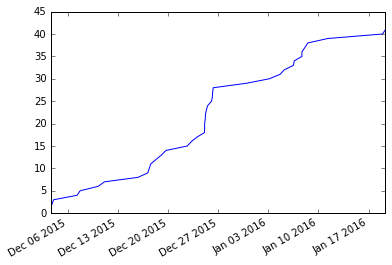

In [10]:
ts = pd.Series(np.ones(len(star_events)), index=pd.to_datetime([e.created_at for e in reversed(star_events)]))
ts = ts.cumsum()
ts.plot()

问题来了， github API 只能返回大概300条最近的事件, 而且还可能包含其他类型的事件。
这个的数据太少了， 对于一些很活跃的仓库，1天的star 数就可能超过这个值。

### github-archive 

https://www.githubarchive.org/ 解决了这个问题, 保存了所有历史的事件。

有几种方式可以使用这个数据，

 * 下载原始的数据，自己解析
 * 查询保存在 Google Big Query 里面的数据
 
我们使用第二种方法, 来导出一份，某个仓库的所有历史star 数据。 
我们先看一下repo 的一些基本信息，作为查询数据库时候的条件. 

In [12]:
repo = Github().get_repo(repo_fullname)
print(repo.stargazers_count)
print(repo.created_at.strftime("%Y-%m-%d"))

604
2013-07-21


目前，似乎 Google Big Query Web UI， 无法正常使用。 

我们使用 bq 这个命令行工具， 并且在 Google Cloud Shell 环境中执行这个操作。

Google Cloud Shell 的启动和配置请看官方文档。  

数据表分成两种，2015年之前和2015 年之后。

2015 年前的数据已经把Payload 展开了， 每年有一张表。 

```bash
~/github-spread-analyze$ bq ls githubarchive:month
  tableId   Type   
 --------- ------- 
  201102    TABLE  
  201104    TABLE  
  201107    TABLE  
  201108    TABLE  
  201109    TABLE  
  201110    TABLE  
  201201    TABLE  
  ....
```

```bash
~/github-spread-analyze$ bq show githubarchive:month.201201
Table githubarchive:month.201201

   Last modified                              Schema                              Total Rows   Total Bytes   Expiration  
 ----------------- ------------------------------------------------------------- ------------ ------------- ------------ 
  07 Jan 06:59:59   |- repository_url: string                                     0            0                        
                    |- repository_has_downloads: boolean                                                                
                    |- repository_created_at: string                                                                    
                    |- repository_has_issues: boolean                                                                  
                    |- repository_description: string                                                                  
                    |- repository_forks: integer                                                                        
                    |- repository_fork: string                                                                          
                    |- repository_has_wiki: boolean                                                                    
                    |- repository_homepage: string                                                                      
                    |- repository_size: integer                                                                        
                    |- repository_private: string                                                                      
                    |- repository_name: string                                                                          
                    |- repository_owner: string                                                                        
                    |- repository_open_issues: integer                                                                  
                    |- repository_watchers: integer                                                                    
                    |- repository_pushed_at: string                                                                    
                    |- repository_language: string                                                                      
                    |- repository_organization: string                                                                  
                    |- repository_integrate_branch: string                                                              
                    |- repository_master_branch: string                                                                
                    |- actor_attributes_gravatar_id: string                                                            
                    |- actor_attributes_type: string                                                                    
                    |- actor_attributes_login: string                                                                  
                    |- actor_attributes_name: string                                                                    
                    |- actor_attributes_company: string                                                               
                    |- actor_attributes_location: string                                                                
                    |- actor_attributes_blog: string                                                                   
                    |- actor_attributes_email: string                                                                  
                    |- created_at: string                                                                              
                    |- public: boolean                                                                                  
                    |- actor: string                                                                                    
                    |- payload_head: string                                                                                               ......
                    ....
                    ...
                    ..
                    .
                    |- url: string                                                                                       
                    |- type: string                                                                                      
```

2015年之后的数据是有嵌套的。 

```bash
~/github-spread-analyze$ bq ls githubarchive:day
      tableId       Type   
 ----------------- ------- 
  events_20150101   TABLE  
  events_20150102   TABLE  
  events_20150103   TABLE  
  ....
  ....
```

```bash
~/github-spread-analyze$ bq show githubarchive:day.events_20150101
Table githubarchive:day.events_20150101
   Last modified             Schema             Total Rows   Total Bytes   Expiration  
 ----------------- --------------------------- ------------ ------------- ------------ 
  10 Jan 07:29:39   |- type: string             218938       456421053                 
                    |- public: boolean                                                 
                    |- payload: string                                                 
                    +- repo: record                                                    
                    |  |- id: integer                                                  
                    |  |- name: string                                                 
                    |  |- url: string                                                  
                    +- actor: record                                                   
                    |  |- id: integer                                                  
                    |  |- login: string                                                
                    |  |- gravatar_id: string                                          
                    |  |- avatar_url: string                                           
                    |  |- url: string                                                  
                    +- org: record                                                     
                    |  |- id: integer                                                  
                    |  |- login: string                                                
                    |  |- gravatar_id: string                                          
                    |  |- avatar_url: string                                           
                    |  |- url: string                                                  
                    |- created_at: timestamp                                           
                    |- id: string                      
```

In [ ]:
为了兼容两种不同的数据结构，我们需要生成两个子查询，然后再合并，下面的代码会根据项目的创建时间等信息来生成优化的SQL。 

需要注意一下 Google Big Query 的计费方式，尽可能的只查询需要的字段和范围。 
https://cloud.google.com/bigquery/pricing

In [13]:
import datetime
def make_sql(repo_full_name):
    repo_owner, repo_name = repo_full_name.split("/", 1)
    repo = Github().get_repo(repo_full_name)
    today = datetime.datetime.now()
    post_2015_sql = '''
    SELECT actor.login as actor, created_at
    FROM (TABLE_DATE_RANGE([githubarchive:day.events_], 
      TIMESTAMP('{start_time}'), 
      TIMESTAMP('{end_time}')
    ))
    WHERE type = 'WatchEvent' AND repo.name = "{repo_full_name}"'''
    pre_2015_sql = '''
    SELECT actor, TIMESTAMP(created_at) as created_at
    FROM (TABLE_QUERY([githubarchive:month],
     'table_id >= "{start_month}" AND table_id <= "{end_month}"'
    ))
    WHERE type = 'WatchEvent' AND repository_name = "{repo_name}" AND repository_owner = "{repo_owner}"'''
    sub_queries = []
    if repo.created_at < datetime.datetime(2015, 1, 1):
        sub_queries.append(pre_2015_sql.format(
            start_month=repo.created_at.strftime("%Y%m"),
            end_month="201412",
            repo_name=repo_name,
            repo_owner=repo_owner)
        )
    sub_queries.append(post_2015_sql.format(
        start_time=max(repo.created_at, datetime.datetime(2015, 1, 1)).strftime("%Y-%m-%d"), 
        end_time=today.strftime("%Y-%m-%d"),
        repo_full_name=repo_full_name)
    )
    
    sql = '''SELECT * FROM \n{tables} \nORDER BY created_at ASC'''.format(tables=",\n".join(["(%s\n)" %s for s in sub_queries]))
    
    return sql


In [15]:
print(make_sql(repo_fullname))

SELECT * FROM 
(
    SELECT actor, TIMESTAMP(created_at) as created_at
    FROM (TABLE_QUERY([githubarchive:month],
     'table_id >= "201307" AND table_id <= "201412"'
    ))
    WHERE type = 'WatchEvent' AND repository_name = "vpn-deploy-playbook" AND repository_owner = "ftao"
),
(
    SELECT actor.login as actor, created_at
    FROM (TABLE_DATE_RANGE([githubarchive:day.events_], 
      TIMESTAMP('2015-01-01'), 
      TIMESTAMP('2016-01-19')
    ))
    WHERE type = 'WatchEvent' AND repo.name = "ftao/vpn-deploy-playbook"
) 
ORDER BY created_at ASC


将上面的内容保存到 star_events.sql 中， 然后执行下面的命令， 注意将 -n 后面的参数设置的大于总的star 一点。

cat star_events.sql | bq query -q -n 1000 --format=csv > star_events.csv

将文件下载下到 `data/star_events.csv` 

In [4]:
ts = pd.read_csv('data/star_events.csv', parse_dates=[1], index_col=[1])
ts['count'] = np.ones(len(ts))
ts

,actor,count
created_at,,
2014-04-09 02:01:27,ly,1
2014-05-13 06:11:41,lexrus,1
2014-05-13 09:29:24,guizai,1
2014-05-13 12:00:37,ftao,1
2014-05-27 14:14:06,ftao,1
2014-05-28 06:23:30,voransoy,1
2014-05-28 22:16:24,berstend,1
2014-06-04 05:23:33,wangyandong-ningxia,1
2014-06-12 23:07:27,strcrzy,1


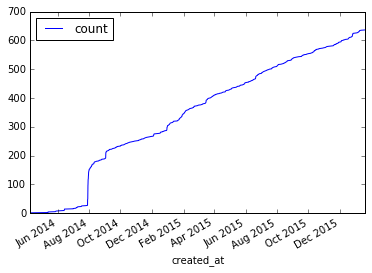

In [5]:
ssum = ts.cumsum()
ssum.plot(kind='line')

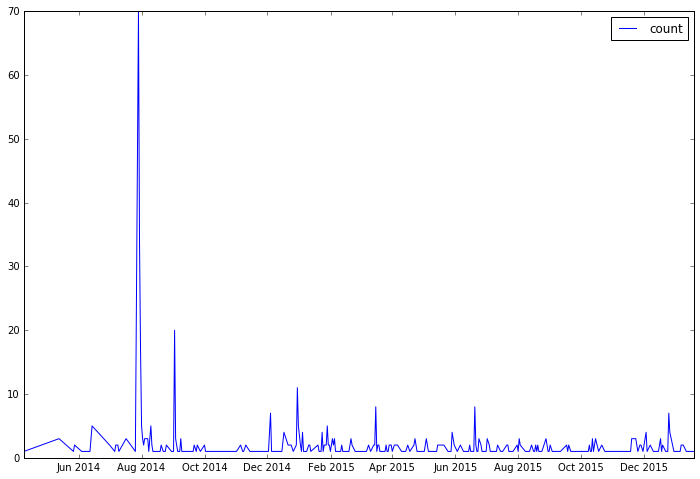

In [8]:
ts_by_day = ts.groupby(lambda x : x.date).sum()
ts_by_day.plot(figsize=(12, 8))


所以我们可以看到有几个尖峰，我们来找到这些都是什么情况？ 

In [8]:
ts_by_day.nlargest(8, columns=['count'])

,count
2014-07-29,70
2014-07-30,34
2014-09-02,20
2014-07-31,17
2014-12-30,11
2015-03-16,8
2015-06-20,8
2014-12-04,7


In [ ]:
我们来最大的尖峰这一天是什么情况？ 

In [9]:
max_day = ts_by_day.nlargest(1, columns=['count']).index[0]
max_day = max_day.strftime("%Y-%m-%d")
ts[max_day]

,actor,count
created_at,,
2014-07-29 02:40:28,iiiyu,1
2014-07-29 02:40:37,maojj,1
2014-07-29 02:41:21,luosky,1
2014-07-29 02:41:58,zzuwangfeng,1
2014-07-29 02:42:50,noark9,1
2014-07-29 02:42:53,noark9,1
2014-07-29 02:42:57,undancer,1
2014-07-29 02:43:28,ewangke,1
2014-07-29 02:43:38,easonoutlook,1


In [ ]:
我们猜想可能是由于某一个 follower 很多的人star 了这个项目所以传播到了很多人。 
我们来画一个这些人的关系图。 

In [10]:
def build_follow_graph(user_names, result=None):
    if result is None:
        result = {}
    github_api_client = get_github_api_client()
    for user_a in user_names:
        print('check user', user_a)
        for user_b in user_names:
            if user_a == user_b:
                continue
            #already cached 
            if result.get(user_a, {}).get(user_b) is not None:
                #print ('skip', user_a, user_b)
                continue
            is_following = False
            try:
                is_following = github_api_client.get_user(user_a).has_in_following(github_api_client.get_user(user_b))
            except:
                print (user_a, user_b)
                traceback.print_exc() 
            if user_a not in result:
                result[user_a] = {}
            result[user_a][user_b] = is_following
    return result

In [11]:
import traceback
import json 
import os
import itertools

def write_cache(path, result):
    with open(path, 'w') as fp:
        json.dump(result,  fp)

def read_cache(path):
    with open(path, 'r') as fp:
        return json.load(fp) 

result = {}
cache_file = 'data/follow_result.json'
if os.path.isfile(cache_file):
    result = read_cache(cache_file)

try:
    build_follow_graph(ts[max_day]['actor'], result)
except:
    traceback.print_exc()
finally:
    write_cache(cache_file, result)


check user iiiyu
check user maojj
check user luosky
check user zzuwangfeng
check user noark9
check user noark9
check user undancer
check user ewangke
check user easonoutlook
check user shaj04
check user trawor
check user 6david9
check user iwill
check user blueseaguo
check user Lcccocoa
check user nixzhu
check user BobCromwell
check user TomLiu
check user nonstriater
check user qiaoxueshi
check user jiaru0730
check user tangqiaoboy
check user LiLejia
check user cgkim
check user ritksm
check user leonlhzhao
check user AlickHill
check user flankerhqd
check user ellochen
check user Slahser
check user syhkiller
check user youngshook
check user puma007
check user crespoxiao
check user bluealert
check user zack119
check user rainyzz
check user tshanceelunico
check user hewigovens
check user chaobj001
check user inmyfree
check user huanglong
check user mingyun
check user iLongfellow
check user youxiachai
check user elephi
check user Pana
check user masdude
check user numbbuaa
check user hetz


In [117]:
import networkx as nx
G = nx.DiGraph()

G.add_nodes_from(result.keys())
for username, following in result.items():
    for to_user, is_following in following.items():
        if is_following:
            G.add_edge(to_user, username)
sorted(G.out_degree().items(), key=lambda x:x[1], reverse=True)


[('tangqiaoboy', 9),
 ('iiiyu', 7),
 ('qiaoxueshi', 6),
 ('ewangke', 2),
 ('nixzhu', 2),
 ('maojj', 2),
 ('trawor', 2),
 ('noark9', 2),
 ('zzuwangfeng', 1),
 ('blueseaguo', 1),
 ('hewigovens', 1),
 ('BobCromwell', 1),
 ('undancer', 1),
 ('TomLiu', 1),
 ('zack119', 0),
 ('youxiachai', 0),
 ('mingyun', 0),
 ('jhsonzhi', 0),
 ('nonstriater', 0),
 ('Slahser', 0),
 ('huanglong', 0),
 ('Pana', 0),
 ('iLongfellow', 0),
 ('mayiwei', 0),
 ('expbenson', 0),
 ('shaj04', 0),
 ('ritksm', 0),
 ('mythlive', 0),
 ('hefnrh', 0),
 ('bluealert', 0),
 ('youngshook', 0),
 ('iwill', 0),
 ('chaobj001', 0),
 ('puma007', 0),
 ('cloudtrends', 0),
 ('JoyZeng', 0),
 ('PeterPan507', 0),
 ('mikurio', 0),
 ('easonoutlook', 0),
 ('elephi', 0),
 ('hetz', 0),
 ('masdude', 0),
 ('inmyfree', 0),
 ('numbbuaa', 0),
 ('syhkiller', 0),
 ('yuchen', 0),
 ('Daniel0829', 0),
 ('sunsongxp', 0),
 ('flankerhqd', 0),
 ('cgkim', 0),
 ('tshanceelunico', 0),
 ('ellochen', 0),
 ('LiLejia', 0),
 ('crespoxiao', 0),
 ('JasperYanky', 0),
 (

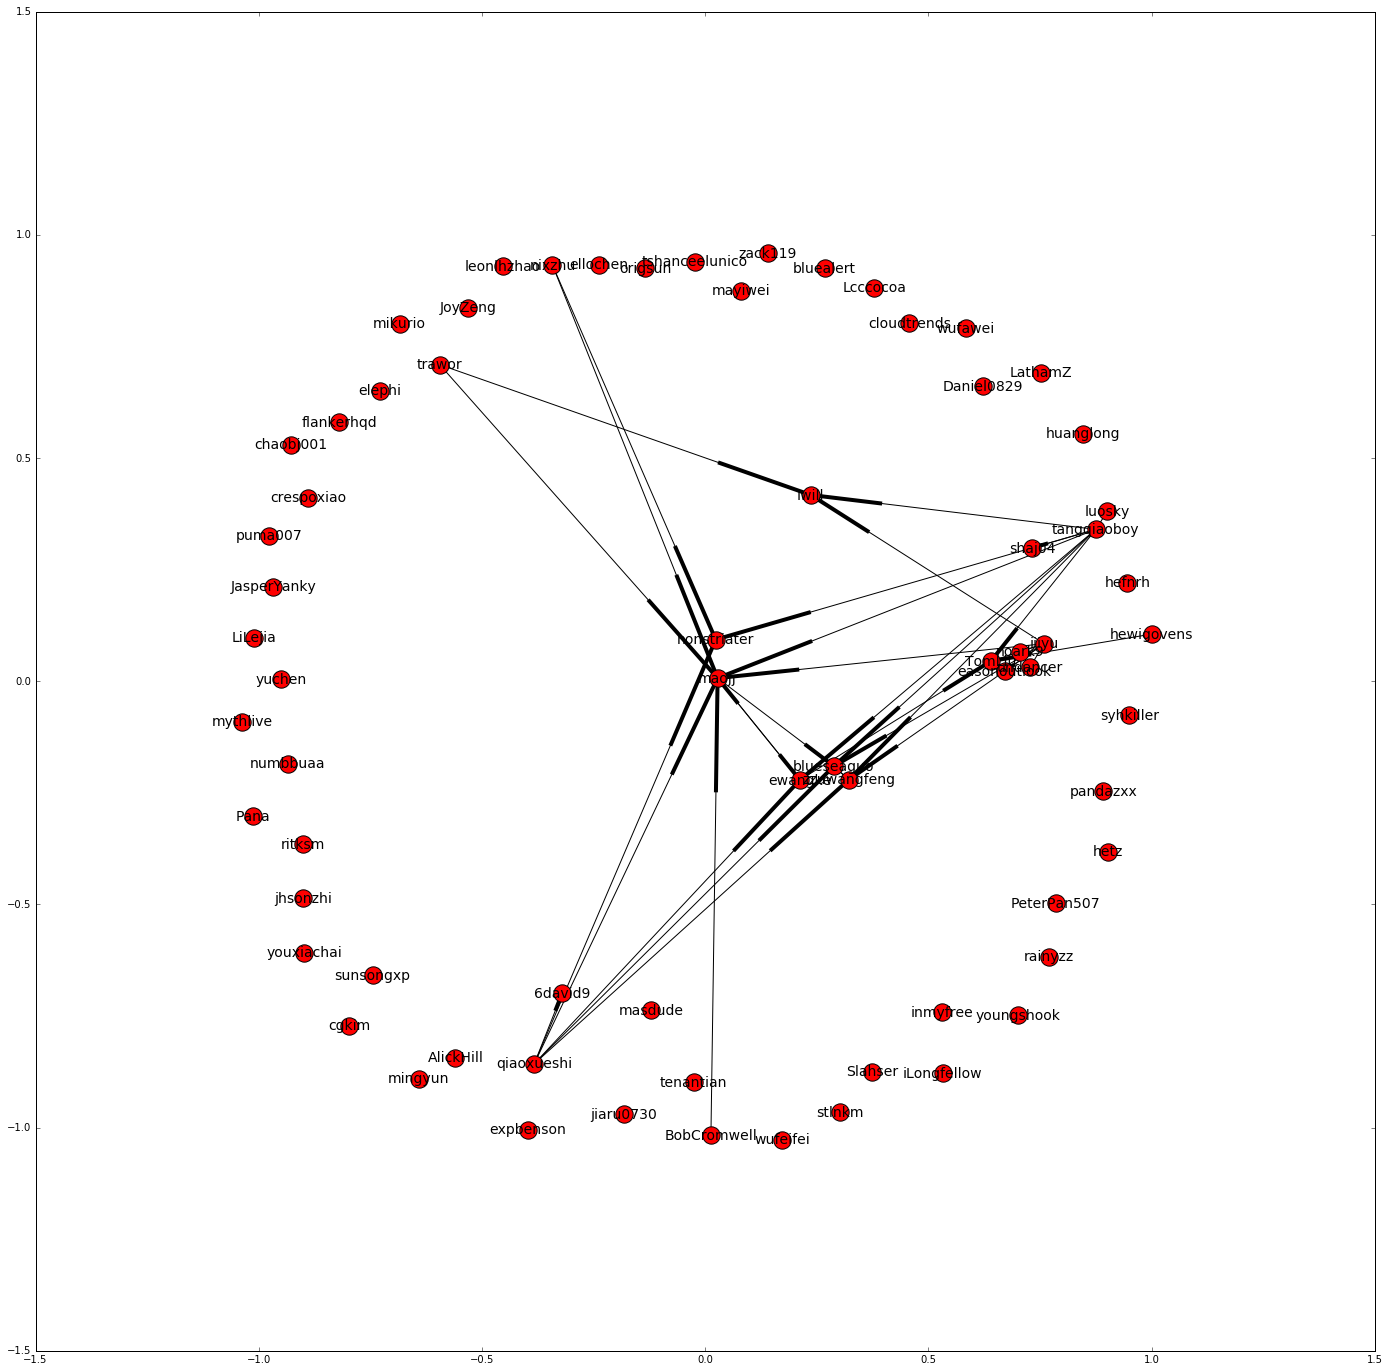

In [121]:
plt.figure(figsize=(24,24))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos, font_size=14)

In [134]:
G.remove_nodes_from(nx.isolates(G)) 

In [141]:
degree_info = [(node, G.in_degree(node), G.out_degree(node)) for node in G.nodes()]

for item in sorted(degree_info, key=lambda x:x[1]):
    print (item)

('trawor', 0, 2)
('nixzhu', 0, 2)
('hewigovens', 0, 1)
('tangqiaoboy', 0, 9)
('BobCromwell', 0, 1)
('qiaoxueshi', 0, 6)
('shaj04', 1, 0)
('luosky', 1, 0)
('easonoutlook', 1, 0)
('iiiyu', 1, 7)
('6david9', 1, 0)
('undancer', 2, 1)
('ewangke', 3, 2)
('nonstriater', 3, 0)
('iwill', 3, 0)
('TomLiu', 3, 1)
('noark9', 3, 2)
('zzuwangfeng', 4, 1)
('blueseaguo', 5, 1)
('maojj', 7, 2)


In [109]:
for node in G.nodes():
    print (node, len(nx.descendants(G, node)))

easonoutlook 0
trawor 10
blueseaguo 1
shaj04 0
maojj 9
nonstriater 0
iwill 0
6david9 0
ewangke 9
hewigovens 10
luosky 0
nixzhu 11
qiaoxueshi 12
iiiyu 9
BobCromwell 10
noark9 9
TomLiu 9
undancer 9
zzuwangfeng 1
tangqiaoboy 13


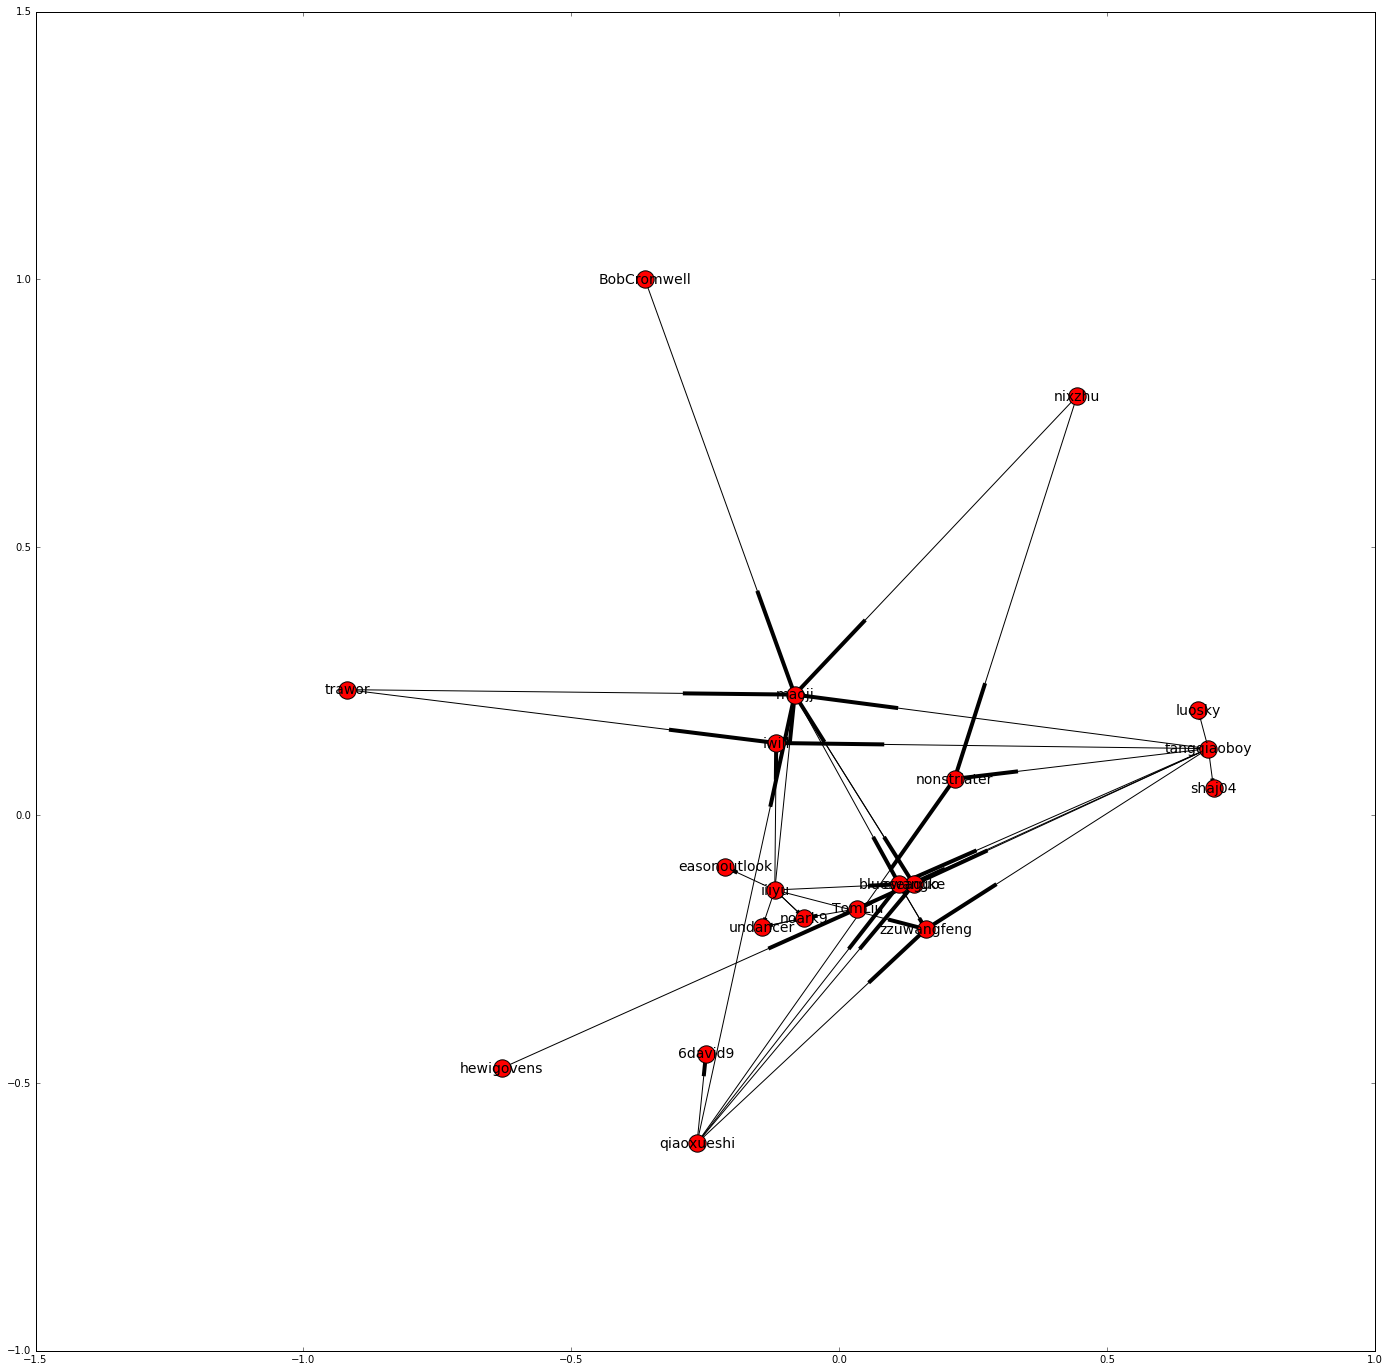

In [123]:
plt.figure(figsize=(24,24))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos, font_size=14)

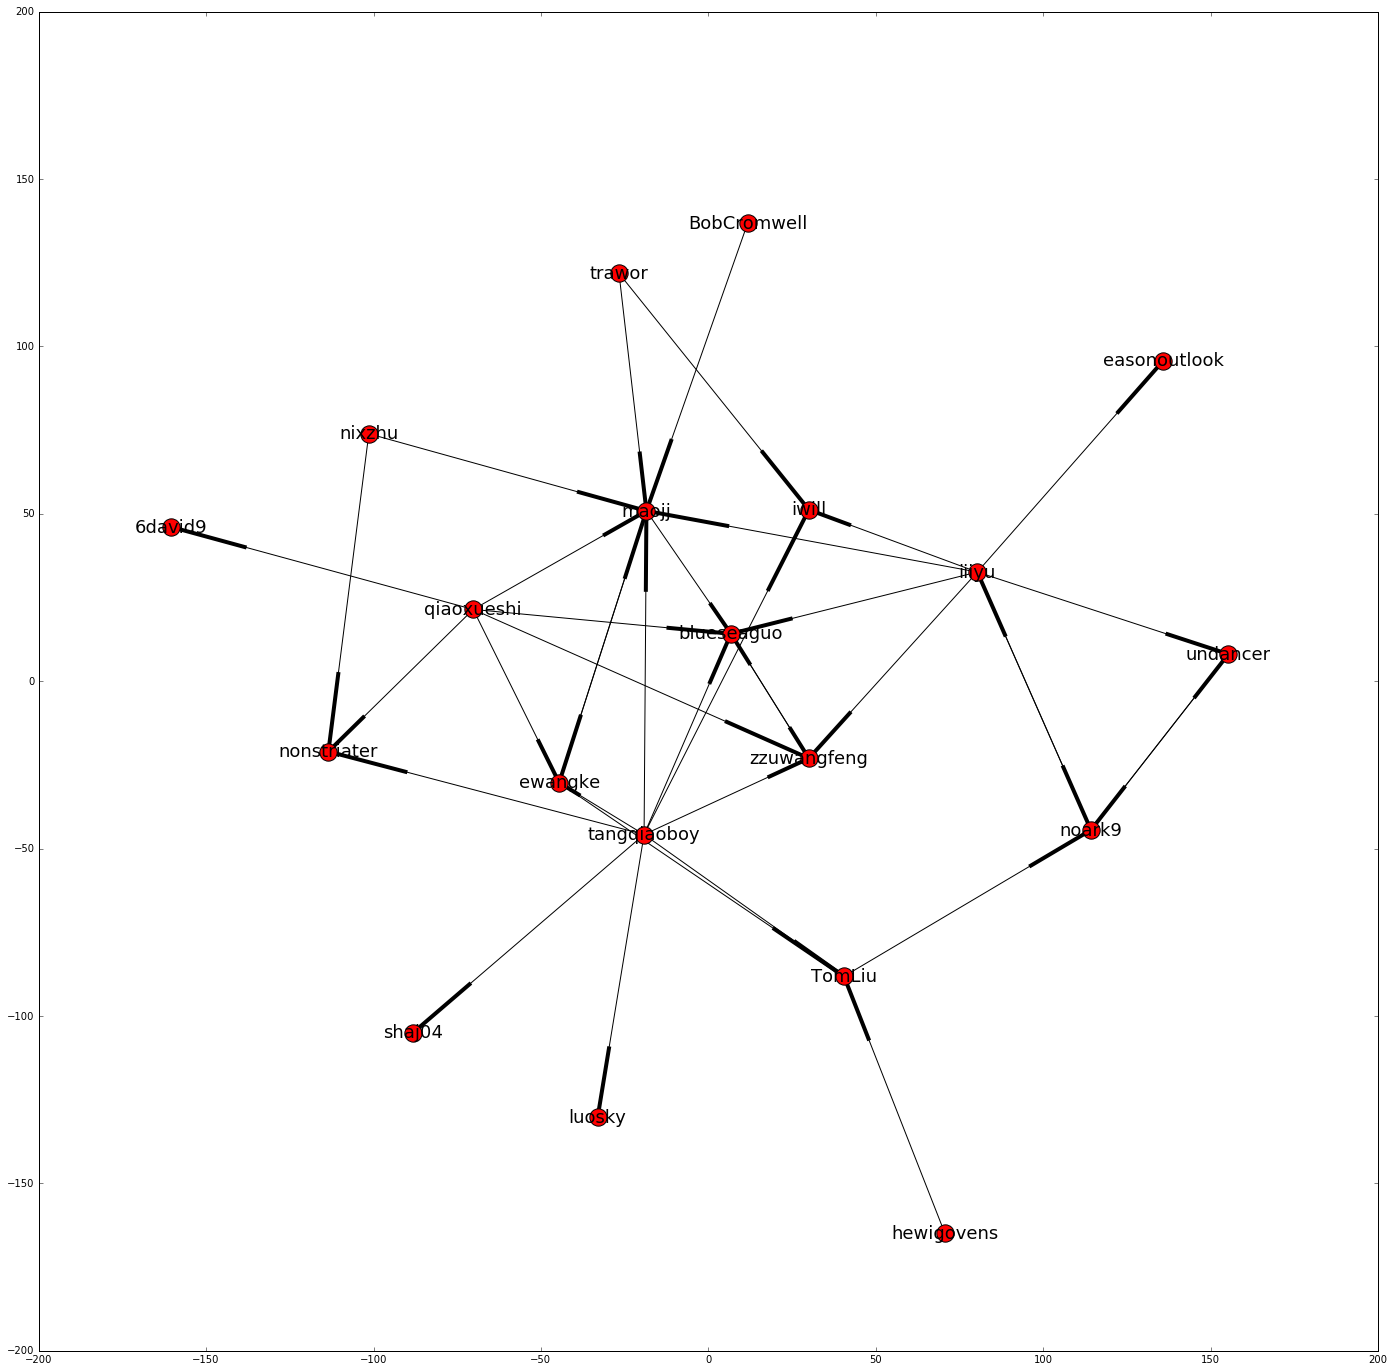

In [131]:
plt.figure(figsize=(24,24))
pos=nx.pygraphviz_layout(G)
nx.draw_networkx(G, font_size=18, pos=pos)

情况似乎和我们想的不完全一致，换个思路？ 我们来看这段时间和这个仓库相关的所有相关事件？ 
```sql

```